In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import anndata as ad
from pyfaidx import Fasta
import scprinter as scp
import os
import pyBigWig

In [3]:
frag_paths=['PRINTdemo/Fragments/'+elem for elem in os.listdir('PRINTdemo/Fragments')]

In [4]:
frag_paths

['PRINTdemo/Fragments/FT6_11_S190_001.fragments.tsv.gz',
 'PRINTdemo/Fragments/FT5_5_S185_001.fragments.tsv.gz',
 'PRINTdemo/Fragments/FT7_11_S200_001.fragments.tsv.gz']

In [20]:
BarcodeGroups=pd.DataFrame({'barcode':['aligned/FT7_11/FT7_11_S200_001','aligned/FT6_11/FT6_11_S190_001','aligned/FT5_5/FT5_5_S185_001'], 
                            'condition':['CEPBA_100','Control_0', 'Myc_100']})
barcodes = np.unique(BarcodeGroups.iloc[:, 0])
Regions=pd.DataFrame({'chr':['chr2'],'Start':[238036072], 'End':[238243952], 'Identifier':['chr2:238036072-238243952']})

In [6]:
barcodes

array(['aligned/FT5_5/FT5_5_S185_001', 'aligned/FT6_11/FT6_11_S190_001',
       'aligned/FT7_11/FT7_11_S200_001'], dtype=object)

# PRINT 

### Loading data and footprinting

In [10]:
#format and order barcodes for scprinter
bcodes=[[elem] for elem in barcodes]
ordered_frag_paths=np.array(frag_paths)[[1,0,2]]

In [11]:
ordered_frag_paths

array(['PRINTdemo/Fragments/FT5_5_S185_001.fragments.tsv.gz',
       'PRINTdemo/Fragments/FT6_11_S190_001.fragments.tsv.gz',
       'PRINTdemo/Fragments/FT7_11_S200_001.fragments.tsv.gz'],
      dtype='<U52')

In [12]:
# import fragments
start = time.time()
printer = scp.pp.import_fragments(
                    path_to_frags=ordered_frag_paths,
                    barcodes=bcodes,
                    savename='PRINTdemo/ivfp.h5ad',
                    genome=scp.genome.hg38,
                    plus_shift=4,
                    minus_shift=-5,
                    min_num_fragments=0, min_tsse=0,
                    sorted_by_barcode=False)
print ("takes", time.time()-start);

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False


Importing fragments:   0%|          | 0/3 [00:00<?, ?it/s]

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 4.131152843750001e-05, shift detected
Minimum MSE is 3.8814394262500006e-05, shift detected
detected plus_shift and minus_shift are 4 -5 for PRINTdemo/Fragments/FT5_5_S185_001.fragments.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 8.407107593750004e-05, shift detected
Minimum MSE is 7.928511426250005e-05, shift detected
detected plus_shift and minus_shift are 4 -5 for PRINTdemo/Fragments/FT6_11_S190_001.fragments.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00033611954468750003, shift detected
Minimum MSE is 0.0003011476780125, shift detected
detected plus_shift and minus_shift are 4 -5 for PRINTdemo/Fragments/FT7_11_S200_001.fragment

  0%|          | 0/3 [00:00<?, ?it/s]

start transferring insertions
takes 280.2094974517822


In [13]:
grouping, uniq_groups=scp.utils.df2cell_grouping(printer, BarcodeGroups)

In [14]:
start = time.time()
scp.tl.get_footprint_score(
    printer,
    grouping,
    uniq_groups,
    Regions,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=32,
    save_key="footprints",
    backed=True,
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.23 GB
Creating footprints in printer.footprintsadata
obs=groups, var=regions
5333 100
Loading insertion profiles


Submitting jobs:   0%|          | 0/99 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/99 [00:00<?, ?it/s]

takes 328.85239696502686


In [8]:
#retrieve footprint scores for our BAC region
footprintdata=printer.footprintsadata['footprints'].obsm[Regions.iloc[0]['identifier']]
np.shape(footprintdata)

(3, 99, 207880)

In [9]:
#close object so that it doesn't get corrupted
printer.close()

### Creating PRINT boxplots

In [10]:
def find_bg_regions(hitdf):
    
    startbps=[]
    endbps=[]
    
    hitdf=hitdf.sort_values(by=['Start'])
    hitdf.reset_index(drop=True, inplace=True)
    
    for index, row in hitdf.iterrows():
        
        if index==0:

            startbp=238036072
            startbps.append(startbp)

            endbp=row['Start']-1
            endbps.append(endbp)

        if index < len(hitdf)-1:

            start=row['End']+1
            startbps.append(start)

            end=hitdf.iloc[index+1]['Start']-1
            endbps.append(end)

        elif index==len(hitdf)-1:

            start=row['End']+1
            startbps.append(start)

            end=238243952
            endbps.append(end)
            
    nothitdf=pd.DataFrame()
    nothitdf['Start']=startbps
    nothitdf['End']=endbps
    nothitdf['identifier']='background'
    nothitdf['Chromosome']='chr2'
    nothitdf['Not Used']=''
    nothitdf['Strand']=1
        
    nothitdf=nothitdf[['Chromosome', 'Start','End','identifier','Not Used', 'Strand']]
        
    nothitdf['Length']=nothitdf['End']-nothitdf['Start']
        
    nothitdf.drop(index=nothitdf.loc[nothitdf['Length']<1].index.to_list(), inplace=True)
        
    return nothitdf

In [147]:
motif = scp.motifs.JASPAR2022_core_Motifs(scp.genome.hg38, bg='genome', mode='moods')
motif.prep_scanner(
    ['CEBPA','MYC','MAX'],
    pseudocount=1e-4,
    pvalue=5e-5,
    window=7
)

scan_results = motif.scan_motif(np.array(Regions), clean=False, verbose=True, strand=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [148]:
scan_result = pd.DataFrame(scan_results)
scan_result = scan_result.drop_duplicates([3, 4, 7, 8])
scan_result['startbp']=scan_result[1]+scan_result[7]
scan_result['endbp']=scan_result[1]+scan_result[8]
scan_result['MotifRegion']=scan_result[0]+':'+scan_result['startbp'].astype(str)+'-'+scan_result['endbp'].astype(str)
scan_result['mid']=(scan_result[7]+scan_result[8])/2
scan_result['midbp']=(scan_result['startbp']+scan_result['endbp'])/2

In [149]:
scan_result['interval'] = scan_result.apply(lambda row: pd.Interval(row[7], row[8]), axis=1)

# Filter rows for 'MAX' and 'MYC' 
MAXresult = scan_result[scan_result[4] == 'MAX']
MYCresult = scan_result[scan_result[4] == 'MYC']

#take intersection of MAX and MYC motifs
MAXoverlaps = MAXresult[MAXresult[3].isin(MYCresult[3]) & MAXresult['interval'].apply(lambda x: any(x.overlaps(y) for y in MYCresult['interval']))]

In [150]:
cebpamotifs=scan_result[scan_result[4]=='CEBPA']

In [152]:
motifdfs=[cebpamotifs, MAXoverlaps]

In [153]:
extractlist=[]
nonextractlist=[]

bac_start=Regions.iloc[0]['Start']

for cond_arg, protein_scan in zip([0,2], motifdfs):

    #define foreground
    filter_scan=pd.DataFrame()
    filter_scan['Start']=(protein_scan['startbp']).astype(int)
    filter_scan['End']=(protein_scan['endbp']).astype(int)

    #define background
    nonmotif=find_bg_regions(filter_scan)

    #specify TF and control condition
    cond=footprintdata[cond_arg]
    control=footprintdata[1]

    extracts=[]
    control_extracts=[]
    nonextracts=[]
    control_nonextracts=[]

    #collect foreground
    for _, row in filter_scan.iterrows():

        start=int(row['Start']-bac_start)
        end=int(row['End']-bac_start)
        mid=int(round((start+end)/2))

        #18th index is equivalent to radius 20 (index 0 corresponds to radius 2)
        extract=cond[18,start:end+1]
        control_extract=control[18,start:end+1]
        
        extracts.append(extract)
        control_extracts.append(control_extract)

    #collect background
    for _, row in nonmotif.iterrows():

        start=int(row['Start']-bac_start)
        end=int(row['End']-bac_start)
        
        #18th index is equivalent to radius 20 (index 0 corresponds to radius 2)
        nonextract=cond[18,start:end+1]
        control_nonextract=control[18,start:end+1]
        
        nonextracts.append(nonextract)
        control_nonextracts.append(control_nonextract)
        
    #concatenate values
    extracts=np.concatenate(extracts)
    nonextracts=np.concatenate(nonextracts)
    control_extracts=np.concatenate(control_extracts)
    control_nonextracts=np.concatenate(control_nonextracts)

    #collect values for tf and control in foreground
    extractlist.append(extracts)
    extractlist.append(control_extracts)

    #collect values for tf and control in background
    nonextractlist.append(nonextracts)
    nonextractlist.append(control_nonextracts)

In [154]:
title_prots=['100nM CEBPA', '100nM MYC&MAX']
prots=['CEBPA', 'MYC&MAX']

2024-11-05 16:11:16 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-05 16:11:16 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3243895/3302975711.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())


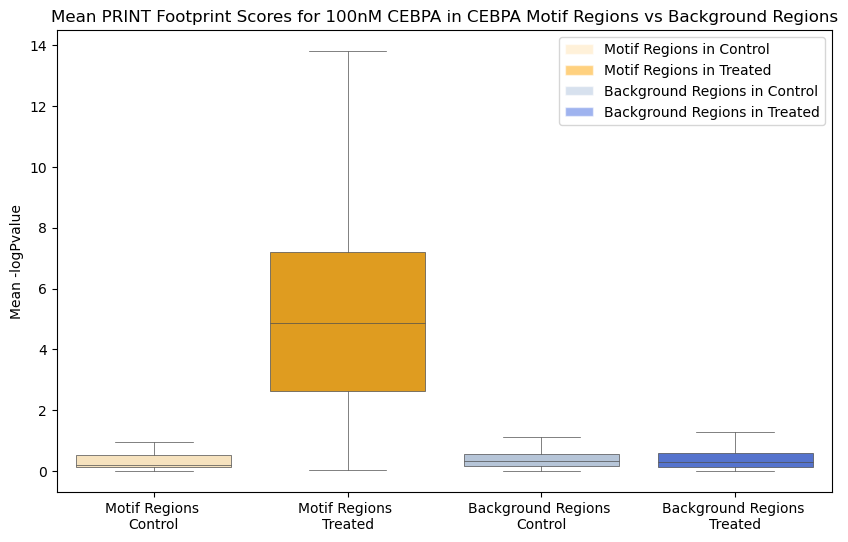

2024-11-05 16:11:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-05 16:11:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3243895/3302975711.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())


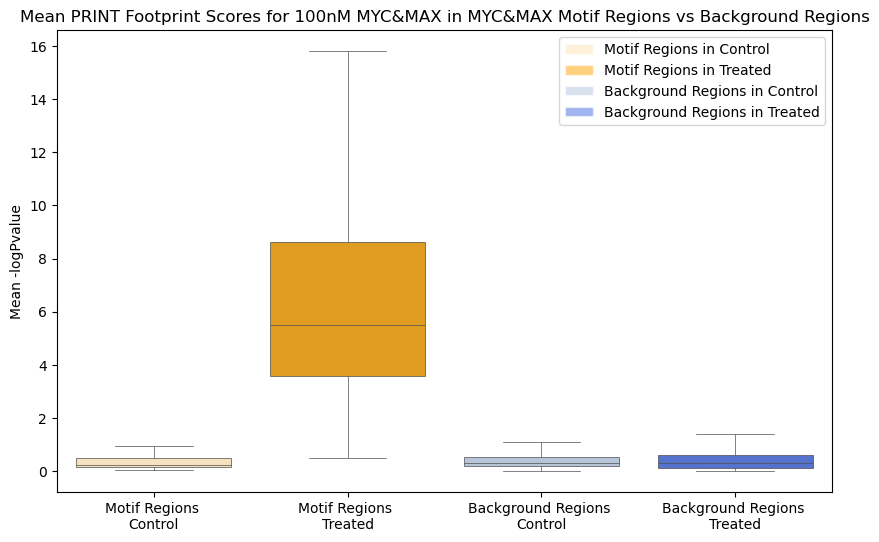

In [157]:
for i in range(2):

    args=[int((2*i)+1),int(2*i)]

    #foreground colors
    colors_extract=['moccasin','orange']
    #background colors
    colors_nonextracts=['lightsteelblue','royalblue']

    colors=['moccasin','orange','lightsteelblue','royalblue']
    
    proxies1=[]
    proxies2=[]
    
    data=[]
    
    for arg, color1, color2 in zip(args, colors_extract, colors_nonextracts):
        
        data.append(extractlist[arg])
        data.append(nonextractlist[arg])
       
        extractproxy = plt.Rectangle((0, 0), 1, 1, fc=color1, edgecolor='white', alpha=0.5)
        nonextractproxy = plt.Rectangle((0, 0), 1, 1, fc=color2, edgecolor='white', alpha=0.5)

        proxies1.append(extractproxy)
        proxies2.append(nonextractproxy)
    
    fig, ax = plt.subplots(figsize=(10, 6)) 
    data=np.array(data, dtype=object)[[0,2,1,3]]
    data=data.tolist()
    
    ax=seaborn.boxplot(data,palette=colors,linewidth=0.5, showfliers=False)
    
    ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())
    legend=plt.legend(proxies1+ proxies2, (np.core.defchararray.add('Motif Regions in ',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions in ',np.array(['Control','Treated']))).tolist())
    legend.set_bbox_to_anchor((1, 1))
    
    plt.ylabel('Mean -logPvalue')
    plt.title('Mean PRINT Footprint Scores for '+ title_prots[int(args[1]/2)]+' in '+prots[int(args[1]/2)]+' Motif Regions vs Background Regions')
    plt.show()

## TOBIAS 

In [161]:
files = os.listdir('PRINTdemo/TOBIAS')

total_tobias=[]
names=[]

for file in files:
    
    if file.endswith('bw'):
    
        tobias=pyBigWig.open('PRINTdemo/TOBIAS/'+file)
        tobiasvals=tobias.values('chr2', 238036072, 238243952)

        total_tobias.append(tobiasvals)
        names.append(file)

In [162]:
#order as in PRINT
ordered_tobias=np.array(total_tobias)[[0,2,1]]
ordered_names=np.array(names)[[0,2,1]]

In [163]:
# TOBIAS test regions, generated in TOBIAS workflow
testregions=pd.read_csv('PRINTdemo/BAC_1kb_windows.even.bed', sep='\t', header=None)

In [164]:
def find_intersection_df(df1, df2):
    
    # Assuming the DataFrames have columns 'chrom', 'start', 'end'
    # Sort and reset index to avoid potential issues
    df1 = df1.sort_values(by=[0, 1, 2]).reset_index(drop=True)
    df2 = df2.sort_values(by=[0, 1, 2]).reset_index(drop=True)
    
    # Initialize lists to store intersecting regions
    intersect_chrom = []
    intersect_start = []
    intersect_end = []
    
    # Iterate through rows of both DataFrames to find intersections
    i, j = 0, 0
    while i < len(df1) and j < len(df2):
        chrom1, start1, end1 = df1.loc[i, 0], df1.loc[i, 1], df1.loc[i, 2]
        chrom2, start2, end2 = df2.loc[j, 0], df2.loc[j, 1], df2.loc[j, 2]
        
        # Check for intersection
        if chrom1 == chrom2 and pd.Interval(start1, end1, closed='right').overlaps(pd.Interval(start2, end2, closed='right')):
            intersect_chrom.append(chrom1)
            intersect_start.append(max(start1, start2))
            intersect_end.append(min(end1, end2))
        
        # Move pointers based on which region ends first
        if end1 < end2:
            i += 1
        else:
            j += 1
    
    # Create DataFrame for intersection results
    intersect_df = pd.DataFrame({
        'chr': intersect_chrom,
        'Start': intersect_start,
        'End': intersect_end
    })
    
    return intersect_df

In [165]:
def find_non_overlapping_regions(df1, df2):
    
    # Result dataframe to store non-overlapping regions
    result = []

    for _, row1 in df1.iterrows():
        
        chrom1, start1, end1 = row1[0], row1[1], row1[2]
        
        non_overlapping_intervals = [(start1, end1)]

        for _, row2 in df2.iterrows():
            
            start2, end2 = row2[1], row2[2]
            new_intervals = []

            for interval in non_overlapping_intervals:
                istart, iend = interval

                if end2 < istart or start2 > iend:
                    # No overlap
                    new_intervals.append((istart, iend))
                else:
                    # Overlapping case, split the interval
                    if start2 > istart:
                        new_intervals.append((istart, start2))
                    if end2 < iend:
                        new_intervals.append((end2, iend))

            non_overlapping_intervals = new_intervals

        for interval in non_overlapping_intervals:
            if interval[0] < interval[1]:
                result.append([chrom1, interval[0], interval[1]])

    result_df = pd.DataFrame(result, columns=['chr', 'Start', 'End'])
    return result_df

In [166]:
#make dfs compatible with defined functions
MAXdf=MAXoverlaps[[0,'startbp','endbp']].rename(columns={'startbp':1,'endbp':2})
CEBPAdf=cebpamotifs[[0,'startbp','endbp']].rename(columns={'startbp':1,'endbp':2})

#Only take motifs and bg from TOBIAS test regions
maxtest_fg=find_intersection_df(testregions, MAXdf)
cebpatest_fg=find_intersection_df(testregions, CEBPAdf)
maxtest_bg=find_non_overlapping_regions(testregions, MAXdf)
cebpatest_bg=find_non_overlapping_regions(testregions, CEBPAdf)

In [167]:
motifdfs=[cebpatest_fg, maxtest_fg]
bgs=[cebpatest_bg, maxtest_bg]

In [168]:
tobiasextractlist=[]
tobiasnonextractlist=[]

bac_start=Regions.iloc[0]['Start']

for cond_arg, protein_scan, bg in zip([0,2], motifdfs, bgs):

     #define foreground
    filter_scan=pd.DataFrame()
    filter_scan['Start']=(protein_scan['Start']).astype(int)
    filter_scan['End']=(protein_scan['End']).astype(int)

     #define background
    nonmotif=bg

    #define condition and control
    tobiascond=ordered_tobias[cond_arg]
    tobiascontrol=ordered_tobias[1]
    
    tobiasextracts=[]
    tobiascontrol_extracts=[]
    tobiasnonextracts=[]
    tobiascontrol_nonextracts=[]

    #collect foreground
    for _, row in filter_scan.iterrows():

        start=int(row['Start']-bac_start)
        end=int(row['End']-bac_start)
        mid=int(round((start+end)/2))
        
        tobiasextract=tobiascond[start:end+1]
        tobiascontrol_extract=tobiascontrol[start:end+1]

        tobiasextracts.append(tobiasextract)
        tobiascontrol_extracts.append(tobiascontrol_extract)

    #collect background
    for _, row in nonmotif.iterrows():

        start=int(row['Start']-bac_start)
        end=int(row['End']-bac_start)
        
        tobiasnonextract=tobiascond[start+1:end]
        tobiascontrol_nonextract=tobiascontrol[start+1:end]

        tobiasnonextracts.append(tobiasnonextract)
        tobiascontrol_nonextracts.append(tobiascontrol_nonextract)


    #concatenate values
    tobiasextracts=np.concatenate(tobiasextracts)
    tobiasnonextracts=np.concatenate(tobiasnonextracts)
    tobiascontrol_extracts=np.concatenate(tobiascontrol_extracts)
    tobiascontrol_nonextracts=np.concatenate(tobiascontrol_nonextracts)

    #collect values for tf and control in foreground
    tobiasextractlist.append(tobiasextracts)
    tobiasextractlist.append(tobiascontrol_extracts)

    #collect values for tf and control in background
    tobiasnonextractlist.append(tobiasnonextracts)
    tobiasnonextractlist.append(tobiascontrol_nonextracts)

In [169]:
title_prots=['100nM CEBPA', '100nM MYC&MAX']
prots=['CEBPA', 'MYC&MAX']

2024-11-05 16:11:37 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-05 16:11:37 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3243895/4179203369.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())


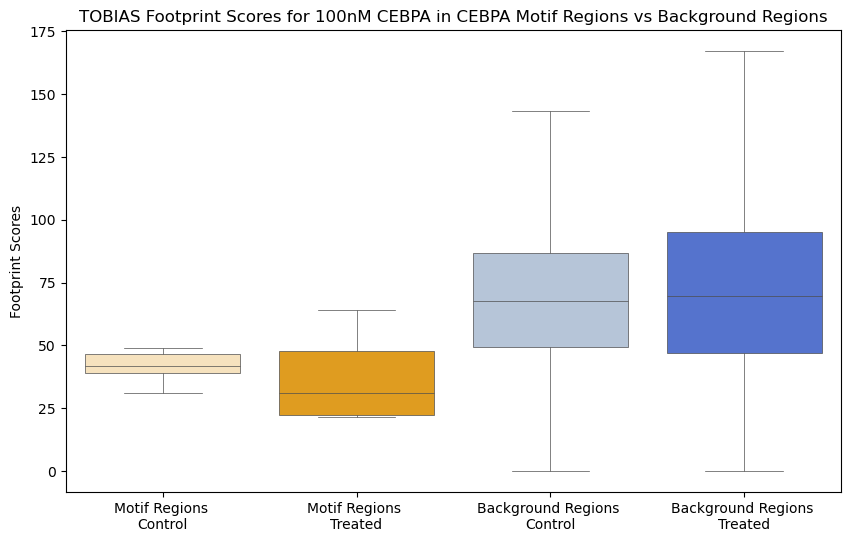

2024-11-05 16:11:37 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-05 16:11:37 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3243895/4179203369.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())


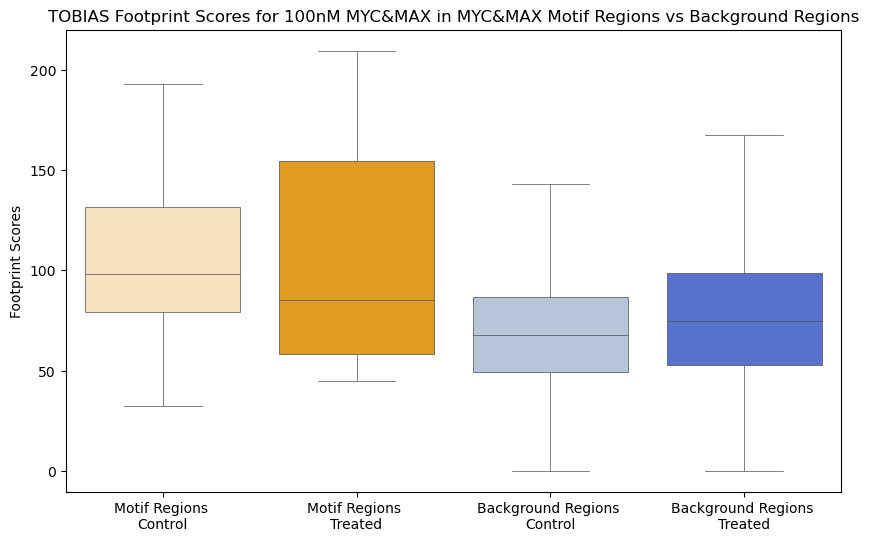

In [170]:
##TOBIAS BOX

for i in range(2):

    args=[int((2*i)+1),int(2*i)]

    colors_extract=['moccasin','orange']
    colors_nonextracts=['lightsteelblue','royalblue']

    colors=['moccasin','orange','lightsteelblue','royalblue']
    
    proxies1=[]
    proxies2=[]
    
    data=[]
    
    for arg, color1, color2 in zip(args, colors_extract, colors_nonextracts):
        
        data.append(tobiasextractlist[arg][~np.isnan(tobiasextractlist[arg])])
        data.append(tobiasnonextractlist[arg][~np.isnan(tobiasnonextractlist[arg])])
       
        extractproxy = plt.Rectangle((0, 0), 1, 1, fc=color1, edgecolor='white', alpha=0.5)
        nonextractproxy = plt.Rectangle((0, 0), 1, 1, fc=color2, edgecolor='white', alpha=0.5)

        proxies1.append(extractproxy)
        proxies2.append(nonextractproxy)
    
    fig, ax = plt.subplots(figsize=(10, 6)) 
    data=np.array(data, dtype=object)[[0,2,1,3]]
    data=data.tolist()
    ax=seaborn.boxplot(data,palette=colors,linewidth=0.5, showfliers=False)
    
    ax.set(xticklabels=(np.core.defchararray.add('Motif Regions \n',np.array(['Control','Treated']))).tolist()+(np.core.defchararray.add('Background Regions \n',np.array(['Control','Treated']))).tolist())

    plt.ylabel('Footprint Scores')

    plt.title('TOBIAS Footprint Scores for '+ title_prots[int(args[1]/2)]+' in '+prots[int(args[1]/2)]+' Motif Regions vs Background Regions')    
    plt.show()